In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/drive-download-20210424T123218Z-001/DAY1/DAY1_vr6_0_0/DAY1_vr6_0_0/4_kadai/2_notebook')
#sys.path.append('/content/drive/MyDrive/drive-download-20210424T123218Z-001/DAY1/DAY1_vr6_0_0/DAY1_vr6_0_0/4_kadai/2_notebook/common')

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
#import common 
#importlib.reload(module1)
#from common import optimizer
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
from common.optimizer import RMSProp
import cv2

In [4]:
!pip3 install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 91 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.2 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
from scipy.misc import imresize
from scipy.ndimage.interpolation import rotate

In [6]:
def check_size(size):
    if type(size) == int:
        size = (size, size)
    if type(size) != tuple:
        raise TypeError('size is int or tuple')
    return size

def random_rotation(image_origin, angle_range=(0, 180)):
    h, w = image_origin.shape
    angle = np.random.randint(*angle_range)
    image_temp = rotate(image_origin, angle)
    image = resize(image_temp, (h, w))
    return image

def center_crop(image_origin, crop_size):
    crop_size = check_size(crop_size)
    h, w = image_origin.shape
    top = (h - crop_size[0]) // 2
    left = (w - crop_size[1]) // 2
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    image = image_origin[top:bottom, left:right]
    return image

def random_crop(image_origin, crop_size):
    crop_size = check_size(crop_size)
    h, w = image_origin.shape
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]
#    image = image[top:bottom, left:right, :]
    image = image_origin[top:bottom, left:right]
    return image

def horizontal_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[:, ::-1]
    return image

def vertical_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[::-1, :]
    return image

def scale_augmentation(image, scale_range, crop_size):
    scale_size = np.random.randint(*scale_range)
    image = imresize(image, (scale_size, scale_size))
    image = random_crop(image, crop_size)
    return image

def resize(image, size):
    size = check_size(size)
    image = imresize(image, size)
    return image

def cutout(image_origin, mask_size, mask_value='mean'):
    image = np.copy(image_origin)
    if mask_value == 'mean':
        mask_value = image.mean()
    elif mask_value == 'random':
        mask_value = np.random.randint(0, 256)

    h, w = image.shape
    top = np.random.randint(0 - mask_size // 2, h - mask_size)
    left = np.random.randint(0 - mask_size // 2, w - mask_size)
    bottom = top + mask_size
    right = left + mask_size
    if top < 0:
        top = 0
    if left < 0:
        left = 0
    image[top:bottom, left:right].fill(mask_value)
    return image

def random_erasing(image_origin, p=0.5, s=(0.02, 0.4), r=(0.3, 3)):
    # マスクするかしないか
    if np.random.rand() > p:
        return image
    image = np.copy(image_origin)

    # マスクする画素値をランダムで決める
    mask_value = np.random.randint(0, 256)

    h, w = image.shape
    # マスクのサイズを元画像のs(0.02~0.4)倍の範囲からランダムに決める
    mask_area = np.random.randint(h * w * s[0], h * w * s[1])

    # マスクのアスペクト比をr(0.3~3)の範囲からランダムに決める
    mask_aspect_ratio = np.random.rand() * r[1] + r[0]

    # マスクのサイズとアスペクト比からマスクの高さと幅を決める
    # 算出した高さと幅(のどちらか)が元画像より大きくなることがあるので修正する
    mask_height = int(np.sqrt(mask_area / mask_aspect_ratio))
    if mask_height > h - 1:
        mask_height = h - 1
    mask_width = int(mask_aspect_ratio * mask_height)
    if mask_width > w - 1:
        mask_width = w - 1

    top = np.random.randint(0, h - mask_height)
    left = np.random.randint(0, w - mask_width)
    bottom = top + mask_height
    right = left + mask_width
    image[top:bottom, left:right].fill(mask_value)
    return image

In [7]:
def noise(image_origin, num):
    image = np.copy(image_origin)
    row,col = image.shape

    # 白
    pts_x = np.random.randint(0, col-1, num) #0から(col-1)までの乱数を作る
    pts_y = np.random.randint(0, row-1, num)
    image[(pts_y,pts_x)] = (255) 

    # 黒
    pts_x = np.random.randint(0, col-1, num)
    pts_y = np.random.randint(0, row-1, num)
    image[(pts_y,pts_x)] = (0)

    return image

In [8]:
def histo_std(image_origin, stdnum):
    row,col = image_origin.shape
    image = np.copy(image_origin)
    image = (image-np.mean(image))/np.std(image)*stdnum+np.mean(image) #標準偏差32,平均120に変更
    image = np.minimum(image,255)
    return image
def histo_mean(image_origin, multinum):
    image = image_origin*multinum 
    image = np.minimum(image,255)
    return image

In [9]:
def expand(image, ratio):
    h, w = image.shape[:2]
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src * ratio
    affine = cv2.getAffineTransform(src, dest)
    return cv2.warpAffine(image, affine, (w, h), cv2.INTER_LANCZOS4) # 補間法も指定できる

In [10]:
def random_shift(image, shifts):
    h, w = image.shape[:2]
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src + shifts.reshape(1,-1).astype(np.float32)
    affine = cv2.getAffineTransform(src, dest)
    return cv2.warpAffine(image, affine, (w, h))

In [11]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        """
        input_size : tuple, 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
        conv_param : dict, 畳み込みの条件
        pool_param : dict, プーリングの条件
        hidden_size : int, 隠れ層のノード数
        output_size : int, 出力層のノード数
        weight_init_std ： float, 重みWを初期化する際に用いる標準偏差
        """
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        pool_output_pixel = filter_num * pool_output_size * pool_output_size # プーリング後のピクセル総数
        
        # 重みの初期化
        self.params = {}
        std = weight_init_std
        self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W2'] = std *  np.random.randn(pool_output_pixel, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std *  np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """
        損失関数
        x : 入力データ
        t : 教師データ
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        t : 教師データ
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [69]:
train_data = np.load("/content/drive/MyDrive/drive-download-20210424T123218Z-001/DAY1/DAY1_vr6_0_0/DAY1_vr6_0_0/4_kadai/1_data/train_data.npy")
train_label = np.load("/content/drive/MyDrive/drive-download-20210424T123218Z-001/DAY1/DAY1_vr6_0_0/DAY1_vr6_0_0/4_kadai/1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [13]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

In [14]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [15]:
def elastic_transform_1(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

In [16]:
def shear_X(image, shear):
    h, w = image.shape[:2]
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    dest[:,0] += (shear / h * (h - src[:,1])).astype(np.float32)
    affine = cv2.getAffineTransform(src, dest)
    return cv2.warpAffine(image, affine, (w, h))
def shear_Y(image, shear):
    h, w = image.shape[:2]
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    dest[:,1] += (shear / w * src[:,0]).astype(np.float32)
    affine = cv2.getAffineTransform(src, dest)
    return cv2.warpAffine(image, affine, (w, h))

In [70]:
lists=[]

In [ ]:
#for i in range(train_data.shape[0]):
#    temp=random_erasing(train_data[i][0], p=1.0, s=(0.02, 0.3), r=(0.3, 3))
#    lists.append(temp)    
#for i in range(train_data.shape[0]):
#    temp=random_erasing(train_data[i][0], p=1.0, s=(0.02, 0.4), r=(0.3, 3))
#    lists.append(temp)    

In [ ]:
#for i in range(train_data.shape[0]):
#    temp=noise(train_data[i][0], 30)
#    lists.append(temp)

In [ ]:
#for i in range(train_data.shape[0]):
#    temp=histo_std(train_data[i][0], np.std(train_data[i][0])*0.8)
#    lists.append(temp)

In [ ]:
#for i in range(train_data.shape[0]):
#    temp=histo_mean(train_data[i][0], 1.2)
#    lists.append(temp)

In [71]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    a = np.random.randint(-1, 1)
    b = np.random.randint(-1, 1)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [ ]:
'''for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.70)
    a = np.random.randint(0, 12)
    b = np.random.randint(0, 12)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [72]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.75)
    a = np.random.randint(0, 10)
    b = np.random.randint(0, 10)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [73]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.75)
    a = np.random.randint(0, 10)
    b = np.random.randint(0, 10)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [74]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.80)
    a = np.random.randint(0, 8)
    b = np.random.randint(0, 8)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [75]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.80)
    a = np.random.randint(0, 8)
    b = np.random.randint(0, 8)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [76]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.85)
    a = np.random.randint(0, 6)
    b = np.random.randint(0, 6)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [77]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.9)
    a = np.random.randint(0, 4)
    b = np.random.randint(0, 4)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [78]:
for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    temp=expand(temp, 0.95)
    a = np.random.randint(0, 2)
    b = np.random.randint(0, 2)
    temp=random_shift(temp,np.array([a,b]))
    temp=random_rotation(temp,(-3,3))
    temp = 255 - temp
    lists.append(temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [ ]:
'''for i in range(train_data.shape[0]):
    temp = np.copy(train_data[i][0])
    temp = 255 - temp
    a = np.random.randint(-3, 3)
    b = np.random.randint(-3, 3)
    temp=shear_X(temp, a)
    temp=shear_Y(temp, b)
    temp = 255 - temp
    lists.append(temp)'''

In [79]:
numpy_array = np.array(lists)
numpy_array = np.reshape(numpy_array, (numpy_array.shape[0], 1, 28, 28))

In [80]:
#numpy_array=np.concatenate([train_data, numpy_array], 0)
numpy_array=np.concatenate([train_data, numpy_array], 0)
train_data = numpy_array

In [46]:
#正規化
#rain_data = (train_data - train_data.min()) / train_data.max()
#rain_data = train_data.astype('float32')

In [81]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (27000, 784)


In [82]:
train_label = np.tile(train_label, (9,1))

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data, train_label,test_size=0.2, random_state=1234,shuffle=True,stratify=train_label)

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(21600, 784) (5400, 784)
(21600, 15) (5400, 15)


In [85]:
X_train = X_train.reshape(-1,1,28,28) # 配列形式の変形
X_test = X_test.reshape(-1,1,28,28) # 配列形式の変形

In [86]:
# Load the MNIST dataset
#import tensorflow as tf
#mnist = tf.keras.datasets.mnist
#(X_train, y_train),(X_test, y_test) = mnist.load_data()

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

train = X_train/255
test = X_test/255
train = train.reshape(-1, 28*28)
test = test.reshape(-1, 28*28)
train_labels = lb.fit_transform(Y_train)
test_labels = lb.fit_transform(Y_test)

In [87]:
train = train.reshape(-1, 1, 28, 28)
test = test.reshape(-1, 1, 28, 28)

In [88]:
x = train
t = train_labels

x = x.reshape(-1,1,28,28) # 配列形式の変形

epochs = 100
batch_size = 400

optimizer = RMSProp(lr=0.01, rho=0.9)

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':50, 'filter_size':5, 'pad':0, 'stride':1},
#                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=200, output_size=15, weight_init_std=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録

    # 訓練データにおけるloss
#     print("calculating train_loss")    
    train_loss.append(snet.loss(x,  t))

#     print("calculating test_loss")
    # テストデータにおけるloss
    test_loss.append(snet.loss(test, test_labels))

#     print("calculating train_accuracy")
    # 訓練データにて精度を確認
    train_accuracy.append(snet.accuracy(x, t))
    
#     print("calculating test_accuracy")
    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(test, test_labels))
    print(snet.accuracy(test, test_labels))

ストリーミング出力は最後の 5000 行に切り捨てられました。
it= 33
it= 34
it= 35
it= 36
it= 37
it= 38
it= 39
it= 40
it= 41
it= 42
it= 43
it= 44
it= 45
it= 46
it= 47
it= 48
it= 49
it= 50
it= 51
it= 52
it= 53
0.9651851851851851
epoch=11
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
it= 21
it= 22
it= 23
it= 24
it= 25
it= 26
it= 27
it= 28
it= 29
it= 30
it= 31
it= 32
it= 33
it= 34
it= 35
it= 36
it= 37
it= 38
it= 39
it= 40
it= 41
it= 42
it= 43
it= 44
it= 45
it= 46
it= 47
it= 48
it= 49
it= 50
it= 51
it= 52
it= 53
0.9596296296296296
epoch=12
it= 0
it= 1
it= 2
it= 3
it= 4
it= 5
it= 6
it= 7
it= 8
it= 9
it= 10
it= 11
it= 12
it= 13
it= 14
it= 15
it= 16
it= 17
it= 18
it= 19
it= 20
it= 21
it= 22
it= 23
it= 24
it= 25
it= 26
it= 27
it= 28
it= 29
it= 30
it= 31
it= 32
it= 33
it= 34
it= 35
it= 36
it= 37
it= 38
it= 39
it= 40
it= 41
it= 42
it= 43
it= 44
it= 45
it= 46
it= 47
it= 48
it= 49
it= 50
it= 51
it= 52
it= 53
0.9681481481481482
epoch=13
i

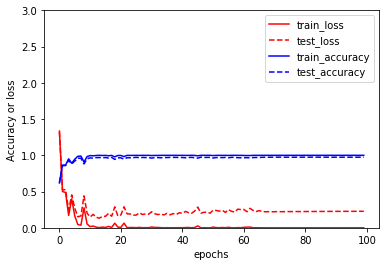

In [89]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

In [90]:
df_log.tail(50)

,train_loss,test_loss,train_accuracy,test_accuracy
50,0.009319,0.242904,0.996667,0.963148
51,0.003068,0.239118,0.999167,0.969444
52,0.001471,0.229937,0.999722,0.969259
53,0.004399,0.241944,0.998935,0.968519
54,0.001605,0.212037,0.999630,0.970926
55,0.006967,0.250641,0.998241,0.966852
56,0.000053,0.227147,1.000000,0.971852
57,0.000025,0.216910,1.000000,0.972963
58,0.002759,0.256930,0.999352,0.967037
59,0.001718,0.252129,0.999306,0.966481


In [91]:
with open("/content/drive/MyDrive/drive-download-20210424T123218Z-001/DAY1/DAY1_vr6_0_0/DAY1_vr6_0_0/4_kadai/2_notebook/katakana_model.pickle", "wb") as f:
    pickle.dump(snet, f)

In [92]:
df_log.tail(100)

,train_loss,test_loss,train_accuracy,test_accuracy
0,1.334771,1.325026,0.618935,0.622222
1,0.500492,0.522118,0.865093,0.856667
2,0.487292,0.526086,0.865602,0.858519
3,0.170487,0.245058,0.951713,0.931481
4,0.399280,0.454285,0.890602,0.880926
...,...,...,...,...
95,0.000003,0.227243,1.000000,0.973704
96,0.000003,0.227109,1.000000,0.974259
97,0.000002,0.227784,1.000000,0.973889
98,0.000002,0.227927,1.000000,0.973889
